# Mean-shift mode seeking

In [23]:
import numpy as np
import cv2
from ex2_utils import generate_responses_1, extract_histogram, backproject_histogram, create_epanechnik_kernel, get_patch, Tracker
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio

In [46]:
def plot_mean_shift_convergence(landscape, all_x, all_y, new_heatmap = True):
    # Visualize the landscape with the computed mode
    #plt.figure(figsize=(6,5))
    x_plot,y_plot = np.arange(landscape.shape[0]), np.arange(landscape.shape[1])
    x_plot,y_plot  = np.meshgrid(x_plot,y_plot)
    # ax.plot_surface(x_plot,y_plot , landscape, alpha = 0.5)
    if new_heatmap:
        sns.heatmap(landscape)
    # Visualize the steps
    plt.scatter(all_x,all_y, color = "green")

In [35]:
# Mean shift algorithm
def mean_shift(pdf, x_start, y_start, kernel_size,termination_criterium = "step_less_than_1", n_iter = 20 ,return_all_x_y = False, seed = 42):
    """Calculates the mean shift algorithm on the provided distribution"""
    # return np.unravel_index(np.argmax(pdf), pdf.shape)[::-1]
    # set the seed for replicability
    np.random.seed(seed)
    # Kernel has to be odd
    if kernel_size % 2 == 0:
        kernel_size += 1
    # Try the Epanechnikov kernel first (basically just multiply)
    x = x_start
    y = y_start
    # Save all points for visualization
    all_x = []
    all_y = []
    # Epsilon to not divide by 0
    eps = 1e-5
    kernel_half = kernel_size // 2
    # Pad the pdf and update the x,y
    pdf_len = pdf.shape[0] # Save the length for later
    pdf = np.pad(pdf, pad_width=kernel_size)
    x += kernel_size
    y += kernel_size

    # Get the matrices of differences
    x_diff_mtx = np.arange(-kernel_half, kernel_half+1)
    x_diff_mtx = np.tile(x_diff_mtx, (kernel_size, 1))
    y_diff_mtx = x_diff_mtx.T


    for i in np.arange(n_iter):
        # Get the weights matrix
        weights_mtx = pdf[y-kernel_half:y+kernel_half+1,x-kernel_half:x+kernel_half+1]
        # If the sum of weigths is currently zero randomly pick another position
        if np.sum(weights_mtx) < eps:
            
            #return x,y
            x = round(np.random.random() *pdf_len) 
            y = round(np.random.random() * pdf_len) 

            continue
        # Change them so that it will be a pdf on the current patch (sum of weights to 1)
        weights_mtx = weights_mtx / (np.sum(weights_mtx))

        # Get the positions matrices for x and y
        x_i_mtx = (x * np.ones_like(x_diff_mtx) + x_diff_mtx)
        y_i_mtx = (y * np.ones_like(x_diff_mtx) + y_diff_mtx)
        # Finish the difference matrices
        # x_diff_mtx = (x_diff_mtx/kernel_size)**2
        # y_diff_mtx = (y_diff_mtx/kernel_size)**2
        # Get the new x and y
        # x_new = np.sum(x_i_mtx * weights_mtx * x_diff_mtx) / (np.sum(weights_mtx * x_diff_mtx) + eps)
        # y_new = np.sum(y_i_mtx * weights_mtx * y_diff_mtx) / (np.sum(weights_mtx * y_diff_mtx) + eps)

        x_new = np.sum(x_i_mtx * weights_mtx) / (np.sum(weights_mtx) + eps)
        y_new = np.sum(y_i_mtx * weights_mtx) / (np.sum(weights_mtx) + eps)

        all_x.append(round(x_new) - kernel_size)
        all_y.append(round(y_new) - kernel_size)

        # Check the termination criterium
        if termination_criterium == "step_less_than_1":
            if (np.abs(x - x_new) < 0.5) and (np.abs(y - y_new) < 0.5):
                #print(x, x_new)
                #print(y, y_new)
                print(i)
                x = round(x_new)
                y = round(y_new)
                break
        # larger step, can only be used for larger kernels
        if termination_criterium == "step_less_than_3":
            if (np.abs(x - x_new) < 1.5) and (np.abs(y - y_new) < 1.5):
                # print(x, x_new)
                # print(y, y_new)
                print(i)
                x = round(x_new)
                y = round(y_new)
                break
        # Stop if the change in density isn't large (say in report that this isnt great so you will only use this to stop if it goes down)
        if termination_criterium == "density_diff" and i > 3:
            if pdf[round(y_new), round(x_new)] - pdf[y,x] < 1e-5:
                x = round(x_new)
                y = round(y_new)
                print(i)
                break
        

        x = round(x_new)
        y = round(y_new)

    if return_all_x_y:
        return all_x,all_y
    return x - kernel_size,y - kernel_size

11


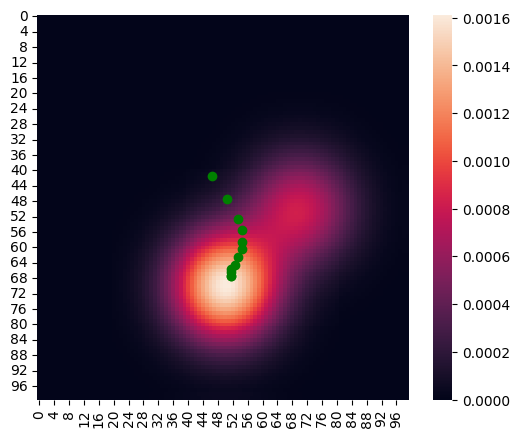

In [31]:
# Load the function landscape
landscape = generate_responses_1()
# Report: if the kernel to small, it doesnt converge
all_x,all_y = mean_shift(landscape,40,34,25, return_all_x_y=True, termination_criterium="density_diff") 

# Visualize the landscape with the computed mode
plot_mean_shift_convergence(landscape, all_x, all_y)

## My own functions

13
11


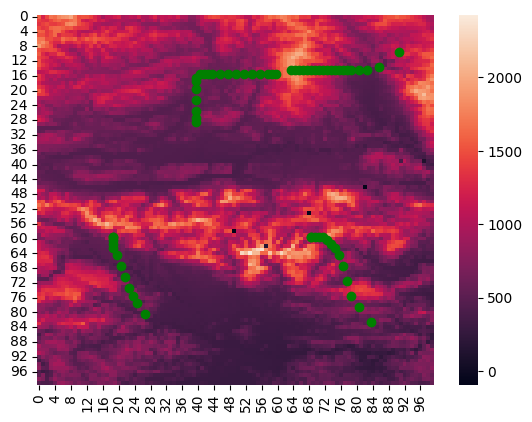

In [82]:
with rasterio.open("mountain_data/L33/N46E014.hgt") as src:
    landscape = src.read(1)
landscape = np.clip(landscape,-100, 3000)
landscape = cv2.resize(landscape, (100,100))
all_x,all_y = mean_shift(landscape,90,90,40, return_all_x_y=True) 
plot_mean_shift_convergence(landscape, all_x, all_y)
all_x,all_y = mean_shift(landscape,99,1,40, return_all_x_y=True) 
plot_mean_shift_convergence(landscape, all_x, all_y, new_heatmap=False)
all_x,all_y = mean_shift(landscape,30,86,40, return_all_x_y=True) 
plot_mean_shift_convergence(landscape, all_x, all_y, new_heatmap=False)
all_x,all_y = mean_shift(landscape,40,30,45, return_all_x_y=True) 
plot_mean_shift_convergence(landscape, all_x, all_y, new_heatmap=False)

16
16


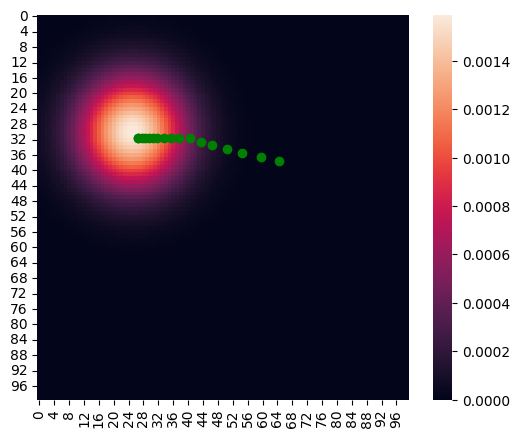

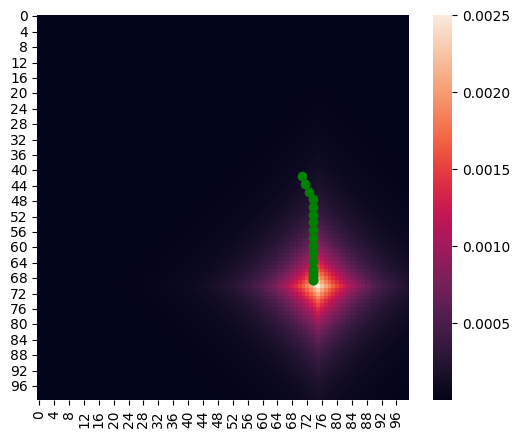

In [236]:
# Defining my own pmfs - use the gaussian distro, and laplacian
size = 100
mew_x, mew_y = size//2 - size//4 , size//2  - size//5
sigma_x, sigma_y = 10,10

x = np.arange(size)
y = np.arange(size)
x,y = np.meshgrid(x,y)

gaussian_pmf = 1/(2 * np.pi * sigma_x * sigma_y) * np.exp(-((x - mew_x) ** 2) / (2 * sigma_x**2) - ((y - mew_y) ** 2) / (2 * sigma_y**2))
all_x,all_y = mean_shift(gaussian_pmf,70,40,15, return_all_x_y=True, termination_criterium="density_diff") 

plot_mean_shift_convergence(gaussian_pmf, all_x, all_y)

# Laplacian
mew_x, mew_y = size//2 + size//4 , size//2  + size//5
b_x, b_y =  10,10
laplacian_pmf = (1 / (4 * b_x * b_y)) * np.exp(-np.abs(x - mew_x) / b_x - np.abs(y - mew_y) / b_y)
all_x,all_y = mean_shift(laplacian_pmf,70,40,15, return_all_x_y=True,termination_criterium="density_diff") 
plot_mean_shift_convergence(laplacian_pmf, all_x, all_y)